# Talktorial 11 (part A)

# CADD web services that can be used via a Python API

__Developed at AG Volkamer, Charité__

Dr. Jaime Rodríguez-Guerra, Dominique Sydow

## Aim of this talktorial

Web services are a convenient way of using software because it frees the user from any installation hassles. A web UI is usually available for easy usage, at the cost of losing the possibility to automate a workflow. Fortunately, the number of web services that provide an API for automated access has been increasing. Some examples in the field of Computer Aided Drug Design include:

- ChEMBL
- RCSB PDB
- KLIFS
- Proteins.plus
- SwissDock

In this notebook, you will learn how to programmatically use online web-services from Python, always in the context of drug design. The end goal will be to build a full pipeline that exclusively relies on web-services, without (almost) any local execution!

__Note__: For simplicity, the full lesson will be divided in three notebooks:

- 11a. Querying KLIFS & PubChem for potential kinase inhibitors
- 11b. Docking the candidates against the target obtained in 11a
- 11c. Assessing the results and comparing against known data

## Learning goals

### Theory

- Types of programmatic access
- Description of the pipeline and the involved webservices

### Practical

- Building the pipeline
- Case study: EGFR inhibitors


## References

Pending.

***


***

## Theory

Now that you have seen how different Python libraries can be used to query online webservices, we will build a pipeline out of onlie webservices!

### Description of the pipeline and the involved webservices


1. Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that provides information about the protein structure (collected from the PDB) of catalytic kinase domains and the interaction with their ligands. We can obtain the curated protein structure from this database and use the ligand information to retrieve similar ligands from other databases, like PubChem or ChEMBL.
2. Using the ligand information provided by KLIFS, we can query PubChem for similar compounds.
3. After having obtained the protein structure(s) and several candidate ligands, we can dock them online with the Vina installation provided in the OPAL web services. We will also query _proteins.plus'_ DoGSiteScorer for probable binding sites where we will dock the compounds. (part B)
4. The results will be visualized with `nglview` and their interactions reported with [PLIP](https://github.com/ssalentin/plip). (part C)

In this part (A) of the talktorial, we will obtain input kinase-inhibitor structures from the _KLIFS_ database and query _PubChem_ for similar compounds that could be tested as potential inhibitors. Relevant output will be written to disk at `data/` so we can use it later on.

#### KLIFS

* Role: Kinase-ligand interaction profiles database
* Website: http://klifs.vu-compmedchem.nl/
* API: Yes, REST-based, Swagger-enabled. No official client. Use `bravado`.
* Documentation: http://klifs.vu-compmedchem.nl/swagger/
* Literature:
    * Nucleic Acids Research, 2016, 44, D1, 6,  D365–D371, https://doi.org/10.1093/nar/gkv1082
    * J. Med. Chem. 2014, 57, 2, 249-277. https://pubs.acs.org/doi/abs/10.1021/jm400378w
    

> Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that revolves around the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Based on the underlying systematic and consistent protocol all (currently human and mouse) kinase structures and the binding mode of kinase ligands can be directly compared to each other. Moreover, because of the classification of an all-encompassing binding site of 85 residues it is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity.

#### PubChem

* Role: Small compounds database
* Website: https://pubchem.ncbi.nlm.nih.gov/
* API: Yes, REST-based. No official client. Use `bravado`.
* Documentation: https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest
* Literature:
    * Nucleic Acids Res. 2019 Jan 8; 47(D1):D1102-1109. https://academic.oup.com/nar/article/47/D1/D1102/5146201

> PubChem is an open chemistry database at the National Institutes of Health (NIH). “Open” means that you can put your scientific data in PubChem and that others may use it. Since the launch in 2004, PubChem has become a key chemical information resource for scientists, students, and the general public. Each month our website and programmatic services provide data to several million users worldwide.



***

## Practical

### Building the pipeline

#### Obtaining information from KLIFS

Choose a random kinase from the EGFR family (in `mol2`) and the corresponding ligands (`SMILES`) from the KLIFS database. We will also obtain the PDB structure of the protein-ligand complex so we can calculate the binding pockets in part B.

In [7]:
from bravado.client import SwaggerClient
KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={'validate_responses': False})

In [8]:
def _all_kinase_families():
    return KLIFS_CLIENT.Information.get_kinase_families().response().result

def _kinases_from_family(family, species="HUMAN"):
    return KLIFS_CLIENT.Information.get_kinase_names(kinase_family=family, species=species).response().result

def _protein_and_ligand_structure(*kinase_ids):
    structures = KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=kinase_ids).response().result
    molcomplex = KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structures[0].structure_ID).response().result
    protein = KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structures[0].structure_ID).response().result
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_ids).response().result
    print(f"Chosen KLIFS entry with PDB ID {structures[0].pdb} with chain {structures[0].chain} and alternate model {structures[0].alt}")
    return molcomplex, protein, [ligand.SMILES for ligand in ligands]

In [26]:
import random
import time

def random_kinase_structure():
    """
    Get a random kinase from a random family
    """
    attempts = 20
    families = _all_kinase_families()
    while attempts:  # some kinase IDs cannot be found in the structure list...
        family = random.choice(families)
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None


def kinase_structure_from_family(family):
    """
    Given a kinase family name (check `_all_kinase_families()`), retrieve a random structure.
    """
    attempts = 20
    while attempts:  # some kinase IDs cannot be found in the structure list...
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None

Let's check if this works. Let's say you want a random kinase from a random family, you can use `step_01_random()` like this:

In [27]:
molcomplex, protein, ligands = random_kinase_structure()

Chosen KLIFS entry with PDB ID 4r7h with chain A and alternate model 
Chosen CSF1R kinase with ID 449 from family PDGFR


In [11]:
ligands

['P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O',
 'CN(C)CCCNS(=O)(=O)c1cccc(c1)Nc2nc3c(c(n2)OCC4CCCCC4)[nH]cn3']

Let's preview the protein with `nglview` and the ligands with `rdkit`. Run the cell below first if you have not installed `nglview` yet.

!pip install nglview
!nglview install
!nglview enable

In [21]:
import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage #Needed to show molecules

def preview_molecule_contents(contents):
    # This is a temporary file, it will be autodeleted
    with NamedTemporaryFile('w+', suffix='.mol2') as f:
        f.write(protein)
        v = nv.show_file(f.name)
    return v

def preview_smiles(smiles):
    print(smiles)
    return Chem.MolFromSmiles(smiles)

def multi_preview_smiles(*smiles):
    legends = [f"{s[:30]}..." for s in smiles]  # shorten the smiles string to avoid text overlap
    molecules = [Chem.MolFromSmiles(s) for s in smiles]
    return MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300), maxMols=len(molecules),
                           legends=legends, useSVG=True)

In [13]:
preview_molecule_contents(protein)

NGLWidget()

P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O


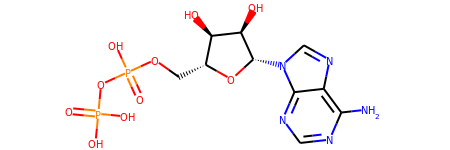

In [22]:
preview_smiles(ligands[0])

#### Query ChEMBL and PubChem

Use the previously obtained `SMILES` string to query similar compounds in PubChem.

In [15]:
import requests
def similar_compounds_pubchem(smiles, threshold=75, n_records=10):
    # Query PubChem for similar compounds
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()['Waiting']['ListKey']
    # Response is async, poll every second for 25 seconds to see if it's done
    attempts = 25
    while attempts:
        r = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON")
        r.raise_for_status()
        response = r.json()
        if 'IdentifierList' in response:
            cids = response['IdentifierList']['CID']
            break
        attempts -= 1
        time.sleep(1)
    else:
        raise IOError("Could not find matches for " + smiles)
    # We get the Compound IDs back, but we need the SMILES
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item['CanonicalSMILES'] for item in r.json()['PropertyTable']['Properties']]

In [30]:
def query_pubchem_for_similar_compounds(ligands):
    # Get the first ligand for the current kinase
    smiles = ligands[0]
    # Look for 10 most similar compounds on pubchem
    return similar_compounds_pubchem(smiles, n_records=10)


Draw the obtained compounds with RDkit

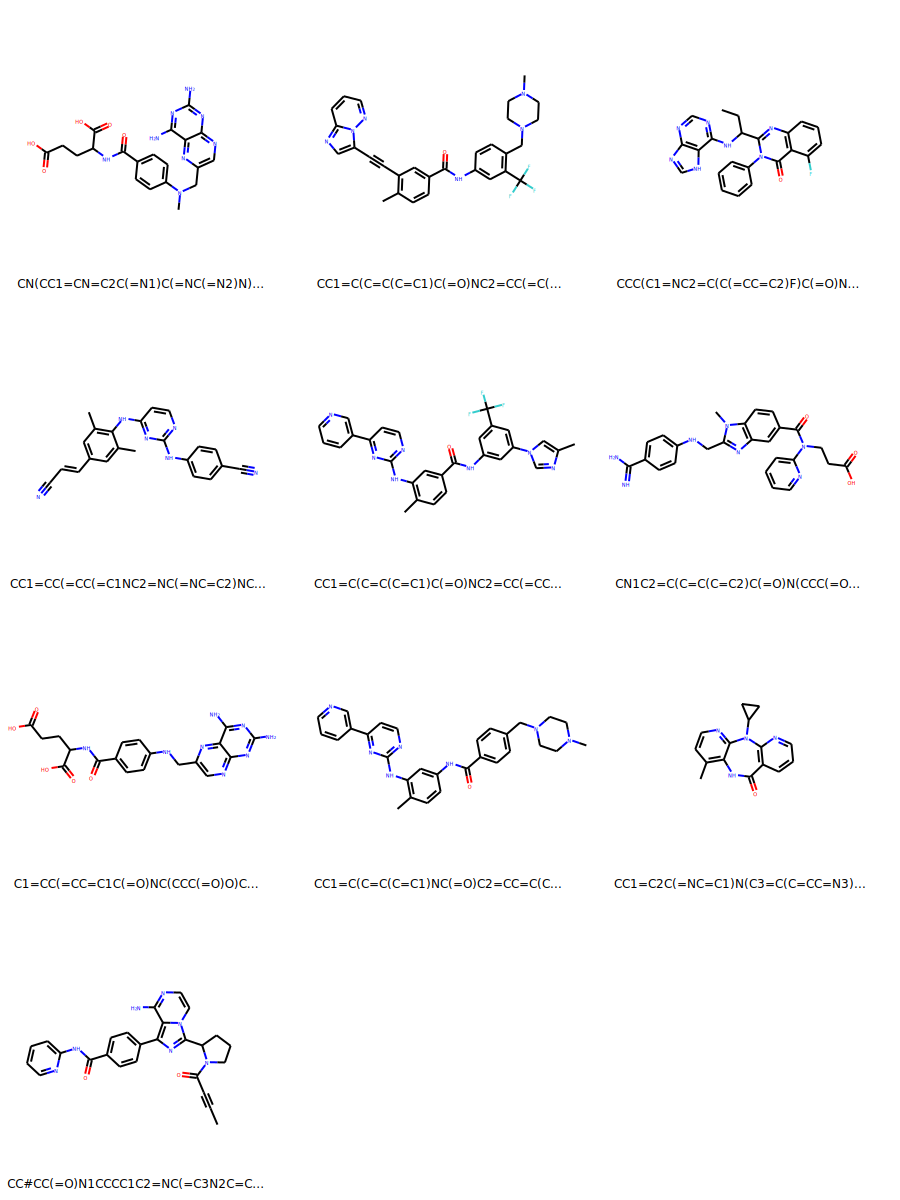

In [29]:
similar_smiles = query_pubchem_for_similar_compounds(ligands)
multi_preview_smiles(*similar_smiles)

### Case study: EGFR

Adapted from [the corresponding Wikipedia article](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor):

>The epidermal growth factor receptor (EGFR) is a member of the ErbB family of receptors, a subfamily of four closely related receptor tyrosine kinases: EGFR (ErbB-1), HER2/neu (ErbB-2), Her 3 (ErbB-3) and Her 4 (ErbB-4). In many cancer types, mutations affecting EGFR expression or activity could result in cancer.
>
>Deficient signaling of the EGFR and other receptor tyrosine kinases in humans is associated with diseases such as Alzheimer's, while over-expression is associated with the development of a wide variety of tumors. Interruption of EGFR signalling, either by blocking EGFR binding sites on the extracellular domain of the receptor or by inhibiting intracellular tyrosine kinase activity, can prevent the growth of EGFR-expressing tumours and improve the patient's condition.


As a result, we are interested in finding potential inhibitors that can target members of the EGFR family. Let's repeat the same steps as above, but now targetting this specific family.

In [31]:
egfr_molcomplex, egfr_protein, egfr_ligands = kinase_structure_from_family('EGFR')
similar_smiles_egfr = query_pubchem_for_similar_compounds(egfr_ligands)

Chosen KLIFS entry with PDB ID 3w33 with chain A and alternate model A
Chosen EGFR kinase with ID 406 from family EGFR


Preview protein

In [32]:
preview_molecule_contents(egfr_protein)

NGLWidget()

Preview EGFR ligand (ATP)

P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O


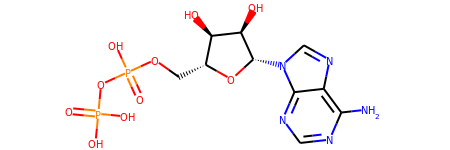

In [33]:
preview_smiles(egfr_ligands[0])

Preview similar ligands

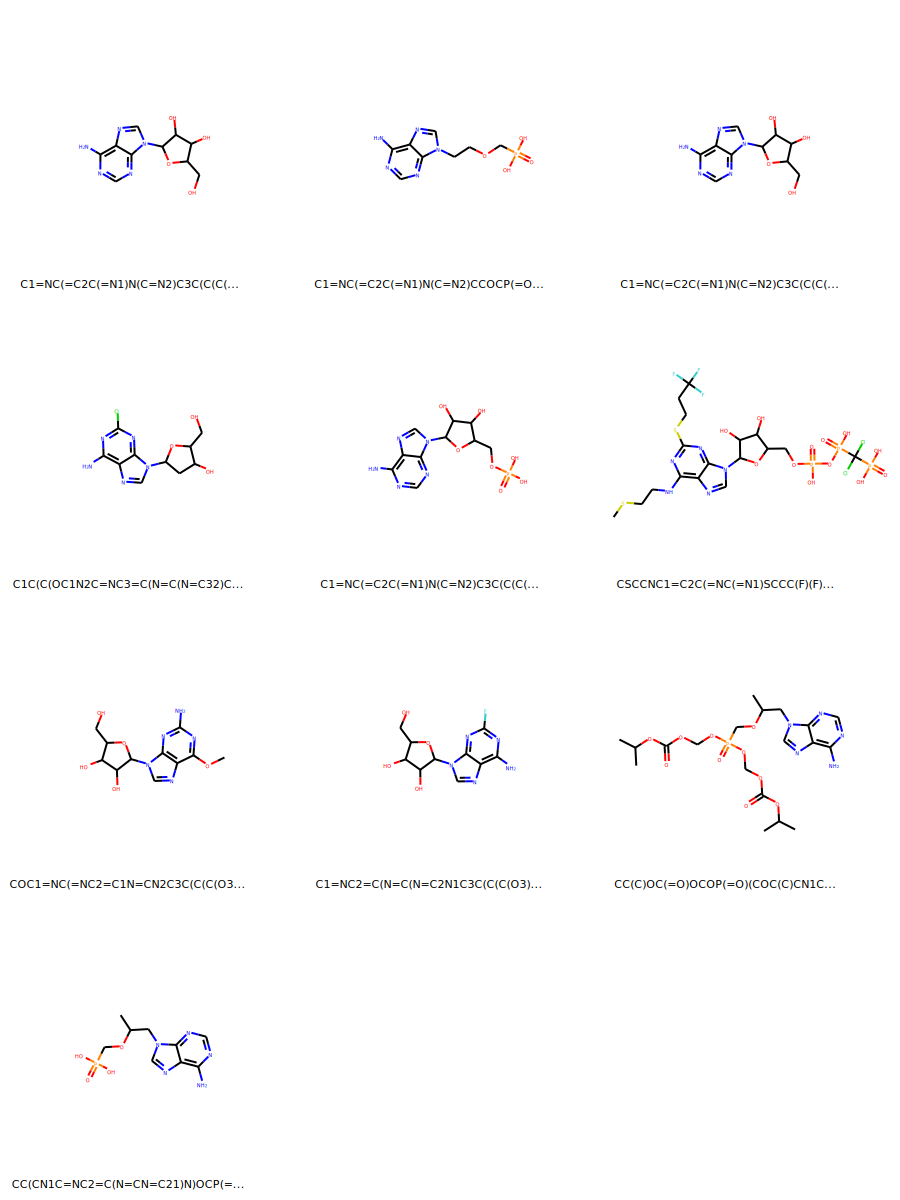

In [34]:
multi_preview_smiles(*similar_smiles_egfr)

Write results to disk for the next part of the talktorial!

In [25]:
import os
os.makedirs('data', exist_ok=True)
with open('data/similar_smiles.txt', 'w') as f:
    f.write('\n'.join(similar_smiles_egfr))
with open('data/protein.mol2', 'w') as f:
    f.write(egfr_protein)
with open('data/complex.pdb', 'w') as f:
    f.write(egfr_molcomplex)

***

## Discussion

In this notebook you have learned how to access and use different web services depending on the technologies available, from well documented API to handcrafted scrapers that try to mimic an actual web browser.

So far, we have queried the KLIFS database for members of the EGFR family, obtaining a kinase structure plus (unsurprisingly) its native ligand, the ATP. Then, PubChem has provided similar compounds with more than a 75% of similarity. We will choose one of those to perform structural modeling on the next parts.


***

## Quiz

- How many kinases does KLIFS provide for the "EGFR" family?
- Can you make the similarity search more strict?
- Is any of the proposed candidates already an approved inhibitor? (Hint: You can _scrape_ [PKIDB](http://www.icoa.fr/pkidb/) and check against the list of smiles)